In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from torch import nn, optim
import codecs
import sys
sys.path.append("../../")  
from utils.recorder_util import ModelResults
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234
# Initializing recorder results

model_name = "LSTM_WORD2VEC"
author = "Andrew Cohn"
seed = 123

recorder = ModelResults(model_name, author, seed)

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 123


Some basic initalization stuffs. Borrwing a lot from assn 3. Now, load our training data set:

In [2]:
train_df = pd.read_csv('../../../trainData/trainData.csv', header=0)
train_df.head(5)

,label,source,text
0,0,1,Help wanted!\n\nThe Seagoing Cowboys program i...
1,0,1,The system of the Electoral College is a widel...
2,1,1,The renowned British statesman Winston Churchi...
3,0,1,"My grandfather would always say ""creativity is..."
4,1,1,In my pursuit to become an assistant manager a...


I will now be borrowing some of Noah's code to preproccess the text, and train word 2 vec:



In [3]:
def preprocess_data(text):
    lower_text = text.lower()
    preprocessed = lower_text.split()
    return preprocessed

train_df["preprocessed_text"] = (train_df["text"]).apply(preprocess_data)

In [4]:
# Import pretrained word2vec model embeddings


def get_embedding(text, embedding_layer, word_to_index):
    # Convert words to indices and filter out words not in the vocabulary
    indices = [word_to_index[word] for word in text if word in word_to_index]
    
    if indices:
        # Convert to a tensor and pass through the embedding layer in one go
        word_indices_tensor = torch.tensor(indices, device=device)
        vectors = embedding_layer(word_indices_tensor).cpu().detach().numpy()
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_layer.embedding_dim)

    
# Load the word2vec model

word2vec_embeddings =  np.load("../../../rawData/gloveEmbeds.npy")
word2vec_tensor = torch.tensor(word2vec_embeddings, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(word2vec_tensor, freeze=True).to(device)
vocab = codecs.open("../../../rawData/vocab.txt").read().split("\n")
vocab_size = len(vocab)

word_to_index = {word: i for i, word in enumerate(vocab)}
x_train = np.array([get_embedding(text, embedding_layer, word_to_index) 
                    for text in train_df["preprocessed_text"]])
y_train = train_df["label"].values
x_train.shape, y_train.shape

((36997, 300), (36997,))

In [5]:
import torch.nn.functional as F
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim, dropout, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a sequence dimension
        lstm_out, _ = self.lstm(x)        
        # Since sequence length is 1, no need to index
        lstm_out = lstm_out.squeeze(1)  # Remove the sequence dimension 
        x = self.dropout(lstm_out)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = torch.zeros(vocab_size, dtype=torch.float32)
        y = torch.tensor(self.y[index], dtype=torch.long)  # Ensure y is a tensor of type long
        for k, v in enumerate(self.x[index]):  # Enumerate over the array
            x[k] = float(v)
        return x, y


In [7]:

# hyperparameters
lr = 1e-3
weight_decay = 1e-5
batch_size = 50 # this model eats vram for breakfast
shuffle = True
n_epochs = 5
input_dim = vocab_size
hidden_dim = 100
hidden_dim2 = 50
output_dim = 1
dropout = 0.3


In [8]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


# initialize the model, loss function, optimizer, and data-loader
model = LSTMModel(input_dim, hidden_dim,hidden_dim2, output_dim, dropout).to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay)
train_ds = MyDataset(
    x_train,
    y_train)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=shuffle)



# lists used to store plotting data
train_loss, train_acc = [], []


/usr/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [9]:
recorder.record_training_start()
for epoch in range(n_epochs):
    losses, acc = [], []
    model.train()

    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        
        
        # Ensure y_true is a tensor
        if not isinstance(y_true, torch.Tensor):
            y_true = torch.tensor(y_true, dtype=torch.long).to(device)

        # Move data to the correct device
        X = X.to(device)
        y_true = y_true.to(device)

        # Clear gradients
        model.zero_grad()

        # Predict label scores
        y_pred = model(X)
        y_true = y_true.unsqueeze(1).float()
        # Compute loss
        loss = loss_func(y_pred, y_true)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Metrics
        pred = (torch.sigmoid(y_pred) > 0.5).long()
        acc.append((pred == y_true).float().mean().item())
        losses.append(loss.detach().cpu().item())

    train_loss.append(np.mean(losses))
    train_acc.append(np.mean(acc))
recorder.record_training_stop()



epoch 1 (train):   0%|          | 0/740 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/740 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/740 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/740 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/740 [00:00<?, ?it/s]

[np.float64(0.2871682418258609), np.float64(0.17109858696978236), np.float64(0.14483120236042382), np.float64(0.1282326375499267), np.float64(0.11858579704563159)]


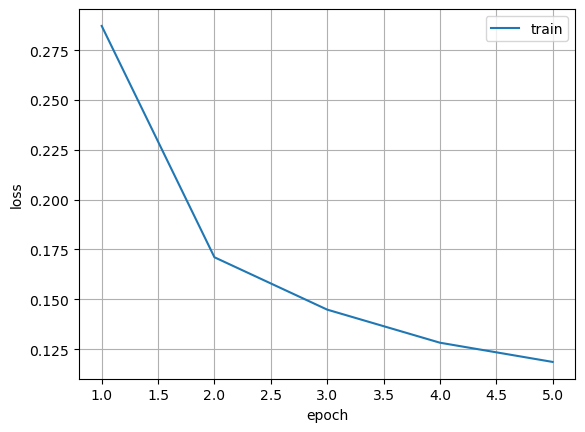

In [10]:
import matplotlib.pyplot as plt

x = np.arange(n_epochs) + 1
print(train_loss)
plt.plot(x, train_loss)

plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

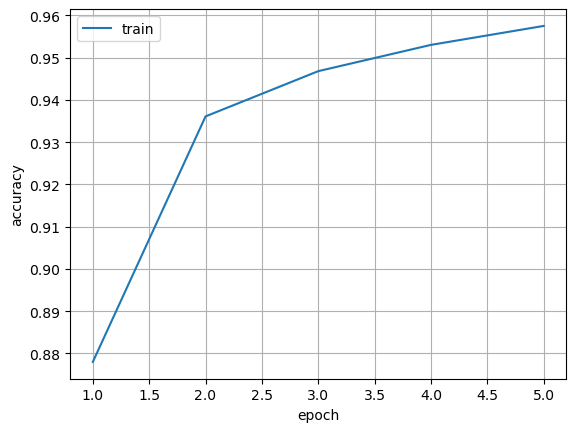

In [11]:
plt.plot(x, train_acc)

plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

In [12]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('../../../testData/testData.csv', header=0)
test_df["preprocessed_text"] = (test_df["text"]).apply(preprocess_data)
x_test = np.array([get_embedding(text, embedding_layer, word_to_index) 
                    for text in test_df["preprocessed_text"]])
y_test = test_df["label"].values
x_test.shape, y_test.shape



((6870, 300), (6870,))

In [13]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

dataset = MyDataset(x_test, y_test)
data_loader = DataLoader(dataset, batch_size=batch_size)
y_pred = []

# disable gradient calculation
with torch.no_grad():
    recorder.record_testing_start()
    for X, _ in tqdm(data_loader):
        X = X.to(device)
        # Predict the probability
        y_pred_prob = model(X).squeeze()  # output probabilities (shape: [batch_size])
        
        # Convert probabilities to binary class labels (0 or 1)
        y_pred_binary = (y_pred_prob > 0.5).int()  # 1 if probability > 0.5, else 0
        
        # Collect predictions
        y_pred.append(y_pred_binary.cpu().numpy())
    recorder.record_testing_stop()
# Convert the list of predictions to a numpy array
y_pred = np.concatenate(y_pred)

# Get the true labels
y_true = dataset.y
recorder.record_performance(y_pred, y_true,None)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=['human', 'bot']))
recorder.write("LSTM_WORD2VEC.csv")


  0%|          | 0/138 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       human       0.93      0.98      0.96      3435
         bot       0.98      0.93      0.95      3435

    accuracy                           0.95      6870
   macro avg       0.96      0.95      0.95      6870
weighted avg       0.96      0.95      0.95      6870

